In [1]:
#
#Extend AI ML Assessment
#

#By: Diego Orellana
#Last Updated: 24-Jun-2021

------
## Challenge
* Given unlabeled images of wood slices (i.e. sections) in the data folder, create a ML model to identify and segment anomalies (i.e.knots, spots, etc).
* Present it as one or more Jupyter Notebooks.
* Describe your steps, we're really interested in how you tackle problems.
* Python and PyTorch preferred.
* Limit as much as possible the usage of classical CV. We are interested in seeing how you would approach this problem from a deep machine learning perspective.
* As you’ll see, the quantity of data is limited on purpose. Capturing the physical world is challenging and we want to see how creative you will be to solve this important and frequent data problem.
* Feel free to contact us for more information and clarifications if needed. You'll receive an invite to join a Slack channel so you can get in touch with us during the process.
* After you finish the challenge, propose how you would improve the model in the near future and how you would transfer learnings to other types of surfaces (i.e. not wood).
------

##### First Thoughts



* Very little data to work with (only 7 2592x1952 jpegs)! One of them duplicated (jpeg "101" is "85", translated and partially darkend).

* Can potentially augment from 7 to 7 + 21 (vertical/horizontal translation, and 180 flip). Augment in other ways (e.g. contrast, hue, noise, etc.)? 

* Still very little data to work with. Need to see what others may have done ("someone, somewhere, has worked on the same or a similar problem"). 

* Found some related work: [identifying anomalies in textured surfaces](https://uwspace.uwaterloo.ca/bitstream/handle/10012/15331/Minhas_ManpreetSingh.pdf?sequence=5&isAllowed=y).
    * Fully unsupervised models noted to not target specific types of anomalies. Won't work for our purposes.
    * Traditional semi-supervised models noted to be computationally expensive, noisy, with some AUC scores just above 0.5
    * Supervised anomaly detection noted as the least flexible, yet [generally] the best performing. Requires plenty of labelled data.
    * AnoNet, a [modified] weakly supervised anomaly detection model, is the key. FCN Design. Compact, which prevents overfitting.
    * Authors claim model can detect anomalies after 53 training images of railway defects (twice our dataset size).
    
    
* Also found this study: [Wood inspection with non-supervised clustering](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.12.2730&rep=rep1&type=pdf).
    * Unsupervised clustering, with self-organizing map (SOM).
    * Many caveats with authors' SOM model. Still required much larger dataset (~850 images).
    * Results in an inaccurate labelling (box around defect, not always centered, sometimes falsely positive). 
    
* And here's a couple tutorials on R-CNNs:
    * https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    * https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49
    

* What if we combine the unsupervised anomaly detection data, with a pre-trained CNN? 
    * Take the inaccurate labels produced from non-supervised clustering, and use as bounding boxes to fine-tune R-CNN.
    * Our data will be the "final test".
    * This could work -- we wouldn't have to worry about using our small sample as training data.
    * May not produce segmentation masks, but let's start here and see what the results are like.


* Other sources:
    * [Deep Learning vs. Traditional CV](https://arxiv.org/ftp/arxiv/papers/1910/1910.13796.pdf#:~:text=There%20are%20clear%20trade%2Doffs,large%20amounts%20of%20computing%20resources.)
    * [Common Wood Defects](https://www.decks.com/how-to/articles/common-wood-defects-types-causes-of-lumber-issues)
    * [Deep Learning with PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf)
    * [Fully Convolution Neural Networks for Semantic Segmentation](https://arxiv.org/abs/1605.06211)
    * [A Compact Convolutional Neural Network for Surface Defect Inspection](https://www.mdpi.com/1424-8220/20/7/1974)
    * [A Fully Convolutional Neural Network for Wood Defect Location and Identification](https://www.researchgate.net/publication/335415310_A_Fully_Convolutional_Neural_Network_for_Wood_Defect_Location_and_Identification)
    * [Detecting Defects on Solid Wood Panels Based on an Improved SSD Algorithm](https://www.researchgate.net/publication/344354395_Detecting_Defects_on_Solid_Wood_Panels_Based_on_an_Improved_SSD_Algorithm)
    * [Wood Defects Data](https://pan.baidu.com/s/1kM5Lh9-s2yImuQE2ks0dqg#list/path=%2F)

In [2]:
#
# **CODE STARTS HERE**
#

In [1]:
import cv2
from datetime import datetime
import gc
import imageio
import IPython.display
from ipywidgets import IntProgress

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
from PIL import Image
import shutil

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


In [2]:
#Working folder, files
workDir = os.getcwd()
originalDataDir = workDir + "\\data\\"
externalDataDir = workDir + "\\WoodDefect\\"

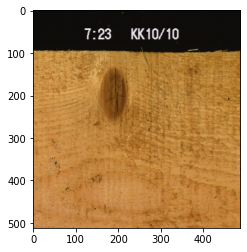

In [3]:
#Before building model, process data from second paper

#Images found here, stored in individual folders
defectImagesDir = externalDataDir + "\\Defects\\"

#Inspecting [randomly selected] sample image
sampleImage = Image.open(defectImagesDir + "\\st1845\\hsk.tmp.ppm")
plt.imshow(np.asarray(sampleImage))


In [6]:
# Question: Will the black space/text interfere with our model training?

# Thought: if our original data included a slice of wood, with a manufacturer's mark (e.g. black label, white text),
# our model would likely not qualify the label as a relevant feature. 

# Resulting Question: Is this a weakness? Is there something we're not thinking of?


In [4]:
#Save all image files to jpeg, in single folder
convertedImagesDir = externalDataDir + "\\ConvertedImages\\"

In [8]:
if not (os.path.isdir(convertedImagesDir)):
    os.mkdir(convertedImagesDir)

for subfolder in os.listdir(defectImagesDir):
    try:
        instanceDir = defectImagesDir + "\\{0}\\".format(subfolder)
        imageFilename = os.listdir(defectImagesDir + "\\{0}\\".format(subfolder))[0]
        instanceImage = Image.open(instanceDir + imageFilename)
        instanceImage.save(convertedImagesDir + subfolder + '.jpg')
    except:
        pass

In [5]:
#Box bounds listed here
boxFile = os.path.join(externalDataDir, "manlabel.txt")

#Headers missing, but appear to be in this order (found by checking against sample image, above)
boxFileHeaders = ['IMAGE_ID', 'MIN_Y', 'MIN_X', 'MAX_Y', 'MAX_X', 'LABEL']

dfBox = pd.read_csv(boxFile, header=None, names = boxFileHeaders, delim_whitespace=True)
print(dfBox.head())
list(dfBox.LABEL.unique())

  IMAGE_ID  MIN_Y  MIN_X  MAX_Y  MAX_X  LABEL
0   st1012     83      0    144     60  sound
1   st1012     83     61    144    121  sound
2   st1012     83    122    144    182  sound
3   st1012     83    183    144    243  sound
4   st1012     83    244    144    304  sound


['sound',
 'dry_knot',
 'resin',
 'resin_pocket',
 'sound_knot',
 'encased_knot',
 'edge_knot',
 'moustache_knot',
 'leaf_knot',
 'core_stripe',
 'horn_knot',
 'small_knot',
 'split',
 'wane',
 'knot_hole',
 'UNKNOWN',
 'bark_pocket',
 'mould',
 'decayed_knot']

In [6]:
#For a given image filename (ID), return list of contiguous bounding boxes
#Why? Authors (and references) noted nxn grid of poorly aligned bounding boxes. Hopefully this optimizes training and performance.

def GetBoundingBoxes(inputImageId, dfInput):
    
    imageId = inputImageId.replace('.jpg', '')
    
    #Return this
    boxesDict = dict(zip(list(dfInput.LABEL.unique()), [[] for i in list(dfInput.LABEL.unique())]))
    #Looks like this  {'sound': [], 'mould': [], ...}
    
    #Filter to items of interest
    dfSubset = dfInput[(dfInput.IMAGE_ID == imageId)&(dfInput.LABEL!='sound')]
    
    gridCount = len(dfSubset)
    usedGridIds = []
    
    while gridCount > 0:
        
        #pick first available row (that hasn't been used)
        availableIndices = [i for i in list(dfSubset.index) if not i in usedGridIds]
        instanceID = availableIndices[0]
        
        #add to list of used IDs
        usedGridIds.append(instanceID)
        
        #values from row of interest
        dfRow = dfSubset[dfSubset.index == availableIndices[0]]
        minY = dfRow.MIN_Y.values[0]
        minX = dfRow.MIN_X.values[0]
        maxY = dfRow.MAX_Y.values[0]
        maxX =  dfRow.MAX_X.values[0]
        boxLabel = dfRow.LABEL.values[0]
        
        #iterate through existing box bounds, try to add to existing box (if possible)
        isUniqueBox = True
        for i in range(0, len(boxesDict[boxLabel])):

            boxList = boxesDict[boxLabel][i]

            #only add to existing box if lower/upper x/y bounds are shared
            if (boxList[0] == minX) or (boxList[1] == minY) or (boxList[2] == maxX) or (boxList[3] == maxY):

                #for contiguous area, take minimum of lower bounds, maximum of upper bounds
                updatedBox = [min(boxList[0], minX), min(boxList[1], minY), max(boxList[2], maxX), max(boxList[3], maxY)]

                boxesDict[boxLabel][i] = updatedBox
                
                #stop iterating if match found
                isUniqueBox = False

                break

            else:
                #got to next box
                pass

        #If not added to existing box, add as own bounding box
        if isUniqueBox:
            boxesDict[boxLabel].append([minX, minY, maxX, maxY])
        
        #update loop.
        gridCount += -1
    
        
    return boxesDict

In [7]:
#For simplicity, let's remove 'UNKNOWN', and group all other labels as much as possible. Will this help generalize some of the features?
labelMap = {
    'sound': 'sound',
     'dry_knot': 'knot',
     'resin': 'resin',
     'resin_pocket': 'pocket',
     'sound_knot': 'knot',
     'encased_knot': 'knot',
     'edge_knot': 'knot',
     'moustache_knot': 'knot',
     'leaf_knot': 'knot',
     'core_stripe': 'stripe',
     'horn_knot': 'knot',
     'small_knot': 'knot',
     'split': 'split',
     'wane': 'wane',
     'knot_hole': 'knot',
     'UNKNOWN': 'UNKNOWN',
     'bark_pocket': 'pocket',
     'mould': 'mould',
     'decayed_knot': 'knot'
}

#List of cleaned labels
uniqueCleanLabels = []
for i in labelMap.values():
    if not i in uniqueCleanLabels and not i == 'UNKNOWN':
        uniqueCleanLabels.append(i)

uniqueCleanLabels.sort()

#Enumerate as indices
boxLabelsDict = dict(zip(uniqueCleanLabels, [i for i in range(1, len(uniqueCleanLabels)+1)]))
print(boxLabelsDict)


{'knot': 1, 'mould': 2, 'pocket': 3, 'resin': 4, 'sound': 5, 'split': 6, 'stripe': 7, 'wane': 8}


In [8]:
#**Code from this cell onwards is taken and modified from multiple sources (listed in intro)

class WoodDataSet(torch.utils.data.Dataset):

    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.boxes = dfBox
        
        self.masks = None

        #Exclude any images without defects, and only those with box data (that doesn't read "unknown"!)
        dfExclusions = dfBox[dfBox.LABEL != 'UNKNOWN']
        dfExclusions = dfExclusions.groupby(['IMAGE_ID']).agg({'LABEL': pd.Series.nunique}).reset_index()
        exclusionsList = list(dfExclusions[dfExclusions.LABEL == 1].IMAGE_ID.unique())

        self.imgs = [i for i in list(sorted(os.listdir(self.root))) if (not i.replace('.jpg', '') in exclusionsList) and i.replace('.jpg', '') in list(dfBox.IMAGE_ID.unique())]

        #**The above reduces our effective training set from 839 to 711**
        

    def __getitem__(self, idx):

        #Get image
        imgPath = self.root + "\\{0}".format(self.imgs[idx])
        img = Image.open(imgPath).convert("RGB")

        #Get boxes dict
        imgBoxesDict = GetBoundingBoxes(self.imgs[idx], dfBox)

        boxes = []
        labels = []

        #Only add boxes/labels that map to clean names
        for boxLabel in imgBoxesDict.keys():
            if labelMap[boxLabel] in boxLabelsDict.keys():      
                for box in imgBoxesDict[boxLabel]:                    
                    boxes.append(box)
                    #labels.append(labelMap[boxLabel])
                    labels.append(boxLabelsDict[labelMap[boxLabel]])
            else:
                pass

        #convert everything to tensors
        #labels = torch.ones((len(boxes), ), dtype=torch.int64)
        labels = torch.as_tensor((labels), dtype=torch.int64)
        iscrowd = torch.zeros((len(boxes), ), dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        imageID = torch.tensor([idx])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": imageID,
            "area": area,
            "iscrowd": iscrowd
        }

        if not self.transforms is None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
#Ready to start training our model

from engine import train_one_epoch, evaluate
import utils
import transforms as T

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# 9 classes: background + 8 anomalies
#{'knot': 1, 'mould': 2, 'pocket': 3, 'resin': 4, 'sound': 5, 'split': 6, 'stripe': 7, 'wane': 8}
numClasses = 9


In [ ]:
#Data: training, texting, and loading

# use our dataset and defined transformations
dataset = WoodDataSet(convertedImagesDir, get_transform(train=True))
dataset_test = WoodDataSet(convertedImagesDir, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [10]:
#CUDA finally working! Call ResNet50, move to GPU

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, numClasses)

if torch.cuda.is_available():
    model.cuda()

In [96]:
#Optimize, configure, set epochs, and train!

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
                 
print("That's it!")

Epoch: [0]  [  0/331]  eta: 0:02:42  lr: 0.000020  loss: 3.2043 (3.2043)  loss_classifier: 2.3536 (2.3536)  loss_box_reg: 0.1389 (0.1389)  loss_objectness: 0.6374 (0.6374)  loss_rpn_box_reg: 0.0744 (0.0744)  time: 0.4900  data: 0.0500  max mem: 6027
Epoch: [0]  [ 10/331]  eta: 0:02:21  lr: 0.000171  loss: 2.5251 (2.3269)  loss_classifier: 2.1427 (1.9169)  loss_box_reg: 0.0643 (0.0714)  loss_objectness: 0.3161 (0.3146)  loss_rpn_box_reg: 0.0166 (0.0240)  time: 0.4402  data: 0.0387  max mem: 6027
Epoch: [0]  [ 20/331]  eta: 0:02:16  lr: 0.000323  loss: 0.9079 (1.5068)  loss_classifier: 0.7044 (1.1408)  loss_box_reg: 0.0643 (0.0831)  loss_objectness: 0.2210 (0.2558)  loss_rpn_box_reg: 0.0200 (0.0272)  time: 0.4349  data: 0.0379  max mem: 6027
Epoch: [0]  [ 30/331]  eta: 0:02:11  lr: 0.000474  loss: 0.4996 (1.1786)  loss_classifier: 0.2001 (0.8546)  loss_box_reg: 0.1119 (0.1012)  loss_objectness: 0.0851 (0.1966)  loss_rpn_box_reg: 0.0200 (0.0262)  time: 0.4343  data: 0.0371  max mem: 6027


In [97]:
#Save the model and state
torch.save(model.state_dict(), "model.pth")
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "ckpt.pth")

In [11]:
#For testing, using our original data
class TestData(torch.utils.data.Dataset):

    def __init__(self, root):
        
        super().__init__()
        
        self.root = root

        self.imgs = [i for i in list(sorted(os.listdir(self.root))) if '.jpg' in i]

    def __getitem__(self, idx: int):

        #Get image
        imgPath = self.root + "\\{0}".format(self.imgs[idx])
        
        img = cv2.imread(imgPath, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0

        img = torchvision.transforms.ToTensor()(img) 

        return img

    def __len__(self) -> int:
        return len(self.imgs)

In [12]:
#Testing -- Setup
model.load_state_dict(torch.load('./model.pth'))
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
#Testing -- Load data, pass to device

#**Machine only has 8GB of memory, so had to evaluate images one by one

originalImageFiles = os.listdir(originalDataDir)

#This is a workaround, to my memory issue
def GetModelOutputForImage(imageShortName):
    
    #Image short name needs to be like '_xx.jpg'
    
    dummyDir = workDir + '\\Dummy Directory\\'
    
    #Delete anything in dummyDir, then copy over target image
    for i in os.listdir(dummyDir):
        os.remove(dummyDir + i)
        
    targetFile = [i for i in originalImageFiles if imageShortName in i][0]

    shutil.copy(originalDataDir + targetFile, dummyDir + targetFile)
    
    return dummyDir + targetFile

In [81]:
#Pick single image, call garbage collection, clear cache, pass data loader

singleImagePath = GetModelOutputForImage('_176.jpg')

gc.collect()
torch.cuda.empty_cache()

testDataset = TestData(workDir + '\\Dummy Directory\\')

testDataLoader = torch.utils.data.DataLoader(
    testDataset, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

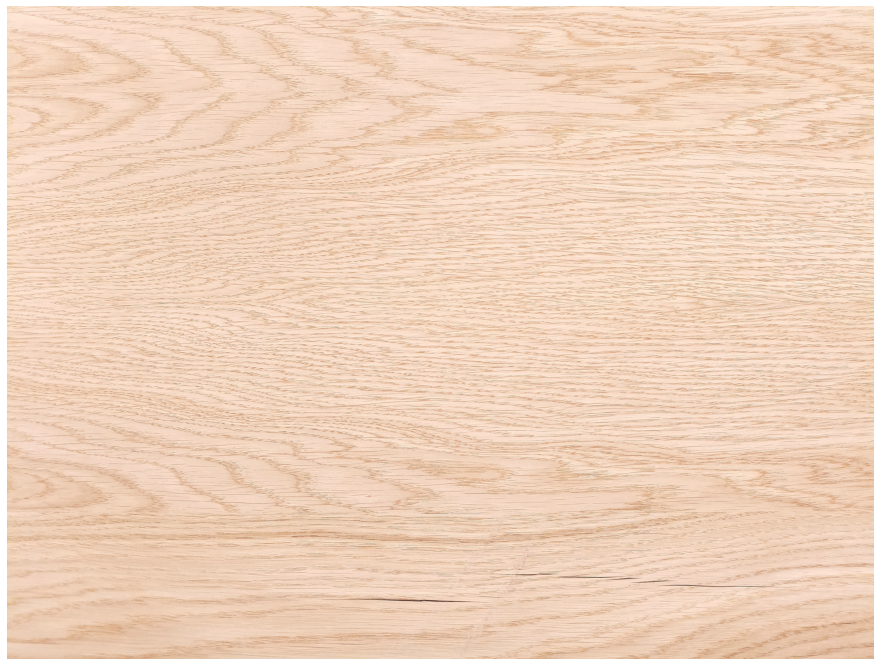

In [82]:
#Testing -- Results

#Threshold score, for bounding boxes
thresholdScore = 0.5

images = next(iter(testDataLoader))
outputs = model(images)

idx = 0
sample = images[idx].permute(1, 2, 0).cpu().numpy()

boxes = outputs[idx]['boxes'].tolist()
scores = outputs[idx]['scores'].tolist()
labels = outputs[idx]['labels'].tolist()

fig, ax = plt.subplots(1, 1, figsize=(24, 12))

image = cv2.imread(singleImagePath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Draw all boxes (with labels) that meet threshold score requirements
for i in range(0, len(boxes)):
    
    if scores[i] >= thresholdScore:
        
        labelText = None
        for k,v in boxLabelsDict.items():
            if v == labels[i]:
                labelText = k
        
        cv2.rectangle(
            image,
            (int(boxes[i][0]), int(boxes[i][1])),
            (int(boxes[i][2]), int(boxes[i][3])),
            (220, 0, 0), 3
        )
        cv2.putText(
            image,
            labelText,
            (int(boxes[i][0]), int(boxes[i][1])-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.2,
            (220, 0, 0), 3
        
        
        )

cv2.imwrite(singleImagePath.replace('Dummy Directory', 'Result').replace('.jpg', '_threshold_mid.jpg'), cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
ax.set_axis_off()

plt.imshow(image)
plt.show()

### End Notes

##### *All image results may be found in the "Result" folder. Each image appears twice: one for a "mid" score threshold of 0.5, and another for "low" 0.1 (to demonstrate additional anomalies, despite model errors with bounding boxes).*


First and foremost, if this were a part of an ML pipeline, my code would need to be significantly cleaned up: logging, improved error handling, and overall parametrization would be beneficial. If not in Jupyter notebook, I would break down functionality into individual files (for ease of maintenance).

Second, my submission may not be exactly what was requested for this assignment: I used an external dataset to train an R-CNN, which in itself does not result in segmentation masks (Fast R-CNN only gives bounding boxes). 

Full disclosure: my resulting model performed poorly. I believe that the external data's poorly aligned bounding boxes (as noted by authors/references) severely affected performance in my model. The final output was subject to a score threhsold of 0.5, which [cosmetically] helped in some cases, but this is not a true fix. Bounding boxes were present for some anomalies only (the large knot in jpeg "85" is completely missed), and appear to be severely affected by contrast and more "anomalous" anomalies.  Setting the threshold to 0.1 shows almost all anomalies (apart from small spots), yet bounding boxes are multiplied and overlap to the point of incoherence. On a more personal note, the operation I introduced to produce contiguous bounding boxes was likely detrimental to the model as well -- this likely also lead to the multiplied/overlapping boxes.


My work here drew from research literature as well as the odd few tutorials I was able to find online. To that end, I agree with some of the potential improvements I read up on. For example:
* Training data: the data I found through my literature review originally contained 839 images, of which I used 711. As the authors (and references) noted, the bounding boxes were poorly aligned and occasionally error prone. All models need a starting point, but this was perhaps one of the greatest drawbacks to performance (IoU scores at the end of epoch 10 were disappointing). 
* Pre-processing: extracting imperfections in lumber as features can likely be improved by removing all colour channels and focusing on saturation/contrast. Normalizing the remaining single colour channel should help with most varieties of wood.  
* Augmentation: part of the code I used contains sections for inverting/flipping training images to artificially increase the sample, although I could have used this to a greater extent.
* Transfer learning vs. Scratch: my model worked by fine-tuning a pre-trained CNN (ResNet50). However, one publication I read described a more simplistic model (AnoNet) that could be trained on a small sample size, yet achieve significant performance gains. This is something I would want to investigate.
* Activation functions: relu and tanh are often discussed and employed, but I've read that vanishing gradients (leading to "dead" weights) can be mitigated by swapping relu with a leaky version. Not sure if relevant here, but I'd be curious to read more on what others think.
* TTA: averaging out predictions for an augmented set could lead to improved performance. This falls under augmentation (noted above), but could also prove useful during final testing (i.e. cleaner and more accurate classification).
* Loss: a decrease in loss with each batch/epoch is noted, but trends asymptotically in early epochs. Would need to take a closer look at other metrics to evaluate if overfitting is a potential issue.  


If I were to be given another chance to build a similar model, but on a wider variety of textures, I would be interested in potentially building a Mask R-CNN model. This would be similar to what I've done, but would instead leverage some of the texture anomaly mask data I've found online (i.e. steel defects, railway cracks, asphalt separation).

Additionally, I would want to incorporate filter banks into the model's kernel; this could facilitate feature extraction across a wider variety of textures, which could allow for significant performance gains (especially for organic textures, as noted in the literature).

<br></br>

Overall, given my personal time constraints, I believe that what I've produced is a decent first step towards building an ML model to identify and segment anomalies in textures. I've hopefully shown what I can accomplish in a relatively short period of time, with minimal direction.

Did I enjoy working on this problem? Absolutely: I feel as though I've learned an immense amount over the last two days. My work is far from perfect, but it has solidified my interest in the subject.
